In [1]:
# ===================================================================
# HARMONIC LOSS VS CROSS-ENTROPY: MNIST COMPARISON EXPERIMENT
#
# Implementation of "Harmonic Loss: Computational Optimizations for Scalable Implementation"
# Original Harmonic Loss: Baek et al. (2025) - "Harmonic Loss Trains Interpretable AI Models"
# Optimized Implementation: kyokopom (@Kyokopom) - github.com/Kitsunp/Harmonic-loss
#
# This notebook compares Cross-Entropy and Harmonic Loss on MNIST classification
# using a simple neural network architecture with ~50K parameters.
# ===================================================================

# ===================================================================
# CELL 1: Setup and Dependencies
# ===================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from collections import defaultdict
import math
import time

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Dependencies loaded successfully!")
print("=" * 60)

Using device: cuda
Dependencies loaded successfully!


In [2]:
# ===================================================================
# CELL 2: Data Preparation
# ===================================================================

print("Loading MNIST Dataset...")

# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])

# Download and load datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# *** TRAINING PARAMETERS - MODIFY HERE ***
BATCH_SIZE = 128
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0
# *** END TRAINING PARAMETERS ***

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print("=" * 60)

Loading MNIST Dataset...
Training samples: 60000
Test samples: 10000
Batch size: 128
Training batches: 469
Test batches: 79


In [3]:
# ===================================================================
# CELL 3: Model Architecture Definition (Single Hidden Layer)
# ===================================================================

class SimpleClassificationNet(nn.Module):
    """
    Simple neural network for MNIST classification with ~50K parameters.

    Architecture:
    - Input: 784 (28x28 flattened)
    - Hidden: 63 neurons + ReLU
    - Output: 10 classes

    Total parameters: ~50,095
    """
    def __init__(self, num_classes=10):
        super(SimpleClassificationNet, self).__init__()

        # *** MODEL ARCHITECTURE PARAMETERS - MODIFY HERE ***
        self.input_size = 784  # 28x28 MNIST images
        self.hidden_size = 64  # Single hidden layer
        self.num_classes = num_classes
        # *** END MODEL ARCHITECTURE PARAMETERS ***

        # Define layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)

        # Final classification layer (shared between CE and Harmonic)
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize network weights using Xavier initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        """Forward pass returning both hidden features and logits"""
        x = self.flatten(x)
        hidden_features = self.fc1(x)  # Final hidden representation
        logits = self.classifier(hidden_features)

        return hidden_features, logits

    def count_parameters(self):
        """Count total number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Test model parameter count
test_model = SimpleClassificationNet()
param_count = test_model.count_parameters()
print(f"Model parameter count: {param_count:,}")
print(f"Target was ~50K parameters: {'✓' if 45000 <= param_count <= 55000 else '✗'}")

# Print detailed parameter breakdown
fc1_params = test_model.fc1.weight.numel() + test_model.fc1.bias.numel()
classifier_params = test_model.classifier.weight.numel() + test_model.classifier.bias.numel()


# Print model architecture
print("\nModel Architecture:")
print(test_model)
print("=" * 60)

Model parameter count: 50,890
Target was ~50K parameters: ✓

Model Architecture:
SimpleClassificationNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=10, bias=True)
)


In [4]:
# ===================================================================
# CELL 4: Harmonic Loss Implementation
# ===================================================================

class HarmonicLoss(nn.Module):
    """
    Optimized Harmonic Loss implementation following the documented algorithms.

    Based on:
    - Original: Baek et al. (2025) "Harmonic Loss Trains Interpretable AI Models"
    - Optimized Implementation: kyokopom "Harmonic Loss: Computational Optimizations"

    Uses two key optimizations:
    1. Algebraic expansion: ||w_i - x||² = ||w_i||² + ||x||² - 2⟨w_i, x⟩
    2. Log-space transformation: z_i = -n * log(d_i)
    """

    def __init__(self, hidden_size, num_classes, harmonic_n=None, eps=1e-6):
        super(HarmonicLoss, self).__init__()

        # *** HARMONIC LOSS PARAMETERS - MODIFY HERE ***
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.eps = eps  # Numerical stability parameter

        # Harmonic exponent (n ≈ √hidden_size following paper)
        if harmonic_n is None:
            self.harmonic_n = 28
        else:
            self.harmonic_n = harmonic_n
        # *** END HARMONIC LOSS PARAMETERS ***

        print(f"Harmonic Loss initialized with n = {self.harmonic_n}")

    def compute_harmonic_logits(self, hidden_features, weight_matrix):
        """
        Compute harmonic logits using optimized algorithm.

        Algorithm (following documented implementation):
        1. y = W^T * x  (standard GEMM)
        2. x² = ||x||²  (hidden state norms)
        3. w² = ||W||²  (weight norms)
        4. d = x² + w² - 2y  (distance reconstruction)
        5. z = -n * log(clamp_min(d, ε))  (harmonic logits)
        """
        batch_size = hidden_features.shape[0]

        # Step 1: Standard matrix multiplication (GEMM)
        y = F.linear(hidden_features, weight_matrix)  # [B, num_classes]

        # Step 2: Compute hidden state norms ||x||²
        x2 = (hidden_features * hidden_features).sum(dim=-1, keepdim=True)  # [B, 1]

        # Step 3: Compute weight norms ||W||²
        w2 = (weight_matrix * weight_matrix).sum(dim=-1)  # [num_classes]

        # Step 4: Reconstruct distances using algebraic identity
        # d = ||x||² + ||W||² - 2⟨w, x⟩
        d = x2 + w2.unsqueeze(0) - 2.0 * y  # [B, num_classes]

        # Step 5: Numerical clamping and log-space transformation
        d_safe = torch.clamp_min(d, self.eps)

        d = torch.sqrt(d_safe)
        z = -self.harmonic_n * torch.log(d)
        return z

    def forward(self, hidden_features, weight_matrix, targets):
        """
        Forward pass computing harmonic loss.

        Args:
            hidden_features: Final hidden layer output [B, hidden_size]
            weight_matrix: Classification layer weights [num_classes, hidden_size]
            targets: Ground truth labels [B]

        Returns:
            loss: Harmonic loss value
            logits: Harmonic logits for accuracy computation
        """
        # Compute harmonic logits
        harmonic_logits = self.compute_harmonic_logits(hidden_features, weight_matrix)

        # Apply standard cross-entropy to harmonic logits
        # (This is mathematically equivalent to harmonic loss)
        loss = F.cross_entropy(harmonic_logits, targets)

        return loss, harmonic_logits
# Test Harmonic Loss
hidden_size = 128  # From our model architecture
num_classes = 10
harmonic_loss = HarmonicLoss(hidden_size, num_classes)
print(f"Harmonic Loss module created successfully")
print("=" * 60)

Harmonic Loss initialized with n = 28
Harmonic Loss module created successfully


In [5]:
# ===================================================================
# CELL 5: Training Functions
# ===================================================================

def train_epoch(model, loss_fn, optimizer, train_loader, device, loss_type="CE"):
    """
    Train model for one epoch.

    Args:
        model: Neural network model
        loss_fn: Loss function (CE or Harmonic)
        optimizer: Optimizer
        train_loader: Training data loader
        device: Device to run on
        loss_type: "CE" or "Harmonic"

    Returns:
        avg_loss: Average loss over epoch
        accuracy: Training accuracy
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        hidden_features, logits = model(data)

        # Compute loss based on type
        if loss_type == "CE":
            # Standard Cross-Entropy Loss
            loss = loss_fn(logits, targets)
            pred_logits = logits
        else:
            # Harmonic Loss
            loss, pred_logits = loss_fn(hidden_features, model.classifier.weight, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(pred_logits.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'Batch [{batch_idx}/{len(train_loader)}] - Loss: {loss.item():.6f}')

    avg_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

def evaluate_model(model, loss_fn, test_loader, device, loss_type="CE"):
    """
    Evaluate model on test set.

    Args:
        model: Neural network model
        loss_fn: Loss function
        test_loader: Test data loader
        device: Device to run on
        loss_type: "CE" or "Harmonic"

    Returns:
        avg_loss: Average test loss
        accuracy: Test accuracy
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            hidden_features, logits = model(data)

            # Compute loss based on type
            if loss_type == "CE":
                loss = loss_fn(logits, targets)
                pred_logits = logits
            else:
                loss, pred_logits = loss_fn(hidden_features, model.classifier.weight, targets)

            total_loss += loss.item()
            _, predicted = torch.max(pred_logits.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

print("Training functions defined successfully")
print("=" * 60)

Training functions defined successfully


In [6]:
# ===================================================================
# CELL 6: Training Loop - Cross-Entropy Model
# ===================================================================

print("TRAINING CROSS-ENTROPY MODEL")
print("=" * 40)

# Create model for Cross-Entropy training
ce_model = SimpleClassificationNet(num_classes=10).to(device)
ce_optimizer = optim.Adam(ce_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
ce_loss_fn = nn.CrossEntropyLoss()

# Training history
ce_train_losses = []
ce_train_accuracies = []
ce_test_losses = []
ce_test_accuracies = []

# Training loop
ce_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    print("-" * 30)

    # Train
    train_loss, train_acc = train_epoch(
        ce_model, ce_loss_fn, ce_optimizer, train_loader, device, "CE"
    )

    # Evaluate
    test_loss, test_acc = evaluate_model(
        ce_model, ce_loss_fn, test_loader, device, "CE"
    )

    # Store metrics
    ce_train_losses.append(train_loss)
    ce_train_accuracies.append(train_acc)
    ce_test_losses.append(test_loss)
    ce_test_accuracies.append(test_acc)

    print(f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.6f} | Test Acc: {test_acc:.2f}%")

ce_training_time = time.time() - ce_start_time
print(f"\nCross-Entropy Training completed in {ce_training_time:.2f} seconds")
print(f"Final Test Accuracy: {ce_test_accuracies[-1]:.2f}%")
print("=" * 60)


TRAINING CROSS-ENTROPY MODEL

Epoch [1/30]
------------------------------
Batch [0/469] - Loss: 3.677301
Batch [100/469] - Loss: 0.295923
Batch [200/469] - Loss: 0.341184
Batch [300/469] - Loss: 0.395992
Batch [400/469] - Loss: 0.343059
Train Loss: 0.402303 | Train Acc: 87.97%
Test Loss: 0.321738 | Test Acc: 90.96%

Epoch [2/30]
------------------------------
Batch [0/469] - Loss: 0.322393
Batch [100/469] - Loss: 0.272034
Batch [200/469] - Loss: 0.357775
Batch [300/469] - Loss: 0.366352
Batch [400/469] - Loss: 0.332645
Train Loss: 0.305125 | Train Acc: 91.37%
Test Loss: 0.286896 | Test Acc: 91.87%

Epoch [3/30]
------------------------------
Batch [0/469] - Loss: 0.181507
Batch [100/469] - Loss: 0.259982
Batch [200/469] - Loss: 0.261100
Batch [300/469] - Loss: 0.396729
Batch [400/469] - Loss: 0.401958
Train Loss: 0.293983 | Train Acc: 91.81%
Test Loss: 0.289413 | Test Acc: 91.97%

Epoch [4/30]
------------------------------
Batch [0/469] - Loss: 0.298874
Batch [100/469] - Loss: 0.26903

In [7]:
# ===================================================================
# CELL 7: Training Loop - Harmonic Loss Model
# ===================================================================

print("TRAINING HARMONIC LOSS MODEL")
print("=" * 40)

# Create model for Harmonic Loss training
harmonic_model = SimpleClassificationNet(num_classes=10).to(device)
harmonic_optimizer = optim.Adam(harmonic_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
harmonic_loss_fn = HarmonicLoss(
    hidden_size=harmonic_model.hidden_size,
    num_classes=10
).to(device)

# Training history
harmonic_train_losses = []
harmonic_train_accuracies = []
harmonic_test_losses = []
harmonic_test_accuracies = []

# Training loop
harmonic_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    print("-" * 30)

    # Train
    train_loss, train_acc = train_epoch(
        harmonic_model, harmonic_loss_fn, harmonic_optimizer, train_loader, device, "Harmonic"
    )

    # Evaluate
    test_loss, test_acc = evaluate_model(
        harmonic_model, harmonic_loss_fn, test_loader, device, "Harmonic"
    )

    # Store metrics
    harmonic_train_losses.append(train_loss)
    harmonic_train_accuracies.append(train_acc)
    harmonic_test_losses.append(test_loss)
    harmonic_test_accuracies.append(test_acc)

    print(f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.6f} | Test Acc: {test_acc:.2f}%")

harmonic_training_time = time.time() - harmonic_start_time
print(f"\nHarmonic Loss Training completed in {harmonic_training_time:.2f} seconds")
print(f"Final Test Accuracy: {harmonic_test_accuracies[-1]:.2f}%")
print("=" * 60)

TRAINING HARMONIC LOSS MODEL
Harmonic Loss initialized with n = 28

Epoch [1/30]
------------------------------
Batch [0/469] - Loss: 2.397706
Batch [100/469] - Loss: 0.342542
Batch [200/469] - Loss: 0.415068
Batch [300/469] - Loss: 0.575989
Batch [400/469] - Loss: 0.387827
Train Loss: 0.473073 | Train Acc: 87.19%
Test Loss: 0.321726 | Test Acc: 90.99%

Epoch [2/30]
------------------------------
Batch [0/469] - Loss: 0.274556
Batch [100/469] - Loss: 0.247999
Batch [200/469] - Loss: 0.293621
Batch [300/469] - Loss: 0.250840
Batch [400/469] - Loss: 0.246898
Train Loss: 0.313565 | Train Acc: 90.89%
Test Loss: 0.288659 | Test Acc: 91.69%

Epoch [3/30]
------------------------------
Batch [0/469] - Loss: 0.273940
Batch [100/469] - Loss: 0.275859
Batch [200/469] - Loss: 0.273468
Batch [300/469] - Loss: 0.256013
Batch [400/469] - Loss: 0.275575
Train Loss: 0.288633 | Train Acc: 91.42%
Test Loss: 0.292087 | Test Acc: 91.31%

Epoch [4/30]
------------------------------
Batch [0/469] - Loss: 0.

GENERATING TRAINING VISUALIZATIONS


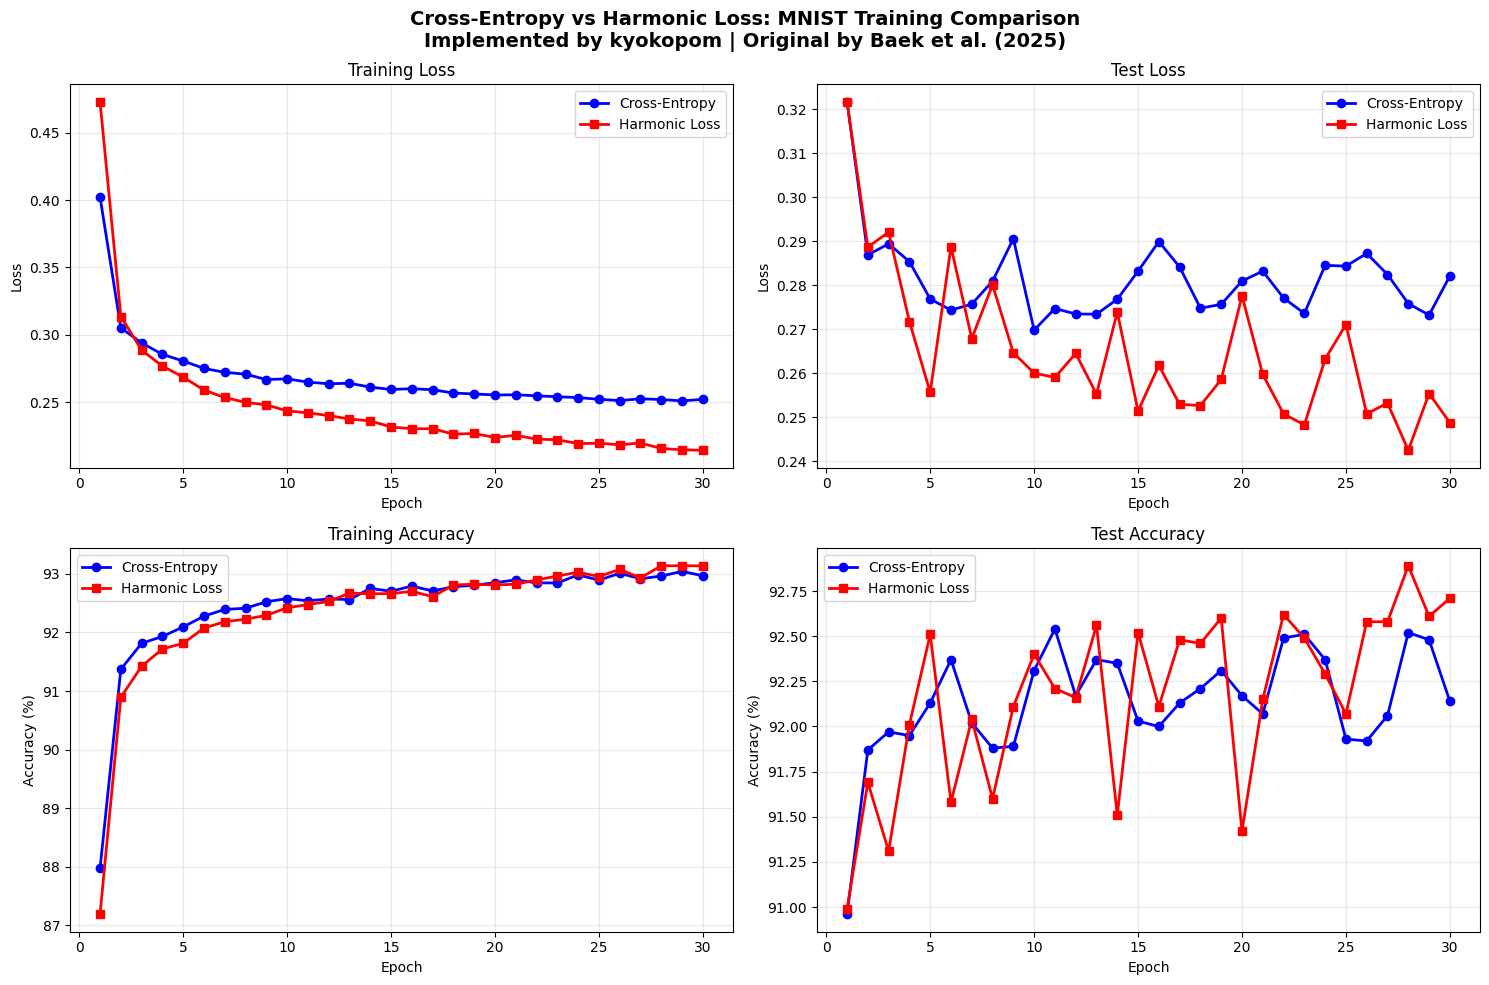


FINAL RESULTS SUMMARY
Cross-Entropy Model:
  - Final Test Accuracy: 92.14%
  - Final Test Loss: 0.282106
  - Training Time: 399.26s

Harmonic Loss Model:
  - Final Test Accuracy: 92.71%
  - Final Test Loss: 0.248735
  - Training Time: 400.91s
  - Harmonic Exponent (n): 28

Performance Difference: +0.57% (Harmonic vs CE)


In [8]:
# ===================================================================
# CELL 8: Results Visualization - Training Curves
# ===================================================================

print("GENERATING TRAINING VISUALIZATIONS")
print("=" * 40)

# Create comprehensive training plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Cross-Entropy vs Harmonic Loss: MNIST Training Comparison\nImplemented by kyokopom | Original by Baek et al. (2025)', fontsize=14, fontweight='bold')

epochs = range(1, NUM_EPOCHS + 1)

# Training Loss
axes[0, 0].plot(epochs, ce_train_losses, 'b-', label='Cross-Entropy', linewidth=2, marker='o')
axes[0, 0].plot(epochs, harmonic_train_losses, 'r-', label='Harmonic Loss', linewidth=2, marker='s')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test Loss
axes[0, 1].plot(epochs, ce_test_losses, 'b-', label='Cross-Entropy', linewidth=2, marker='o')
axes[0, 1].plot(epochs, harmonic_test_losses, 'r-', label='Harmonic Loss', linewidth=2, marker='s')
axes[0, 1].set_title('Test Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Training Accuracy
axes[1, 0].plot(epochs, ce_train_accuracies, 'b-', label='Cross-Entropy', linewidth=2, marker='o')
axes[1, 0].plot(epochs, harmonic_train_accuracies, 'r-', label='Harmonic Loss', linewidth=2, marker='s')
axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Test Accuracy
axes[1, 1].plot(epochs, ce_test_accuracies, 'b-', label='Cross-Entropy', linewidth=2, marker='o')
axes[1, 1].plot(epochs, harmonic_test_accuracies, 'r-', label='Harmonic Loss', linewidth=2, marker='s')
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final comparison metrics
print("\nFINAL RESULTS SUMMARY")
print("=" * 40)
print(f"Cross-Entropy Model:")
print(f"  - Final Test Accuracy: {ce_test_accuracies[-1]:.2f}%")
print(f"  - Final Test Loss: {ce_test_losses[-1]:.6f}")
print(f"  - Training Time: {ce_training_time:.2f}s")
print()
print(f"Harmonic Loss Model:")
print(f"  - Final Test Accuracy: {harmonic_test_accuracies[-1]:.2f}%")
print(f"  - Final Test Loss: {harmonic_test_losses[-1]:.6f}")
print(f"  - Training Time: {harmonic_training_time:.2f}s")
print(f"  - Harmonic Exponent (n): {harmonic_loss_fn.harmonic_n}")
print()

accuracy_diff = harmonic_test_accuracies[-1] - ce_test_accuracies[-1]
print(f"Performance Difference: {accuracy_diff:+.2f}% (Harmonic vs CE)")
print("=" * 60)


VISUAL DIGIT TEMPLATES COMPARISON
Extracting and visualizing digit templates...
Extracting templates for Cross-Entropy...
  - Classifier weights shape: torch.Size([10, 64])
  - FC1 weights shape: torch.Size([64, 784])
Extracting templates for Harmonic Loss...
  - Classifier weights shape: torch.Size([10, 64])
  - FC1 weights shape: torch.Size([64, 784])


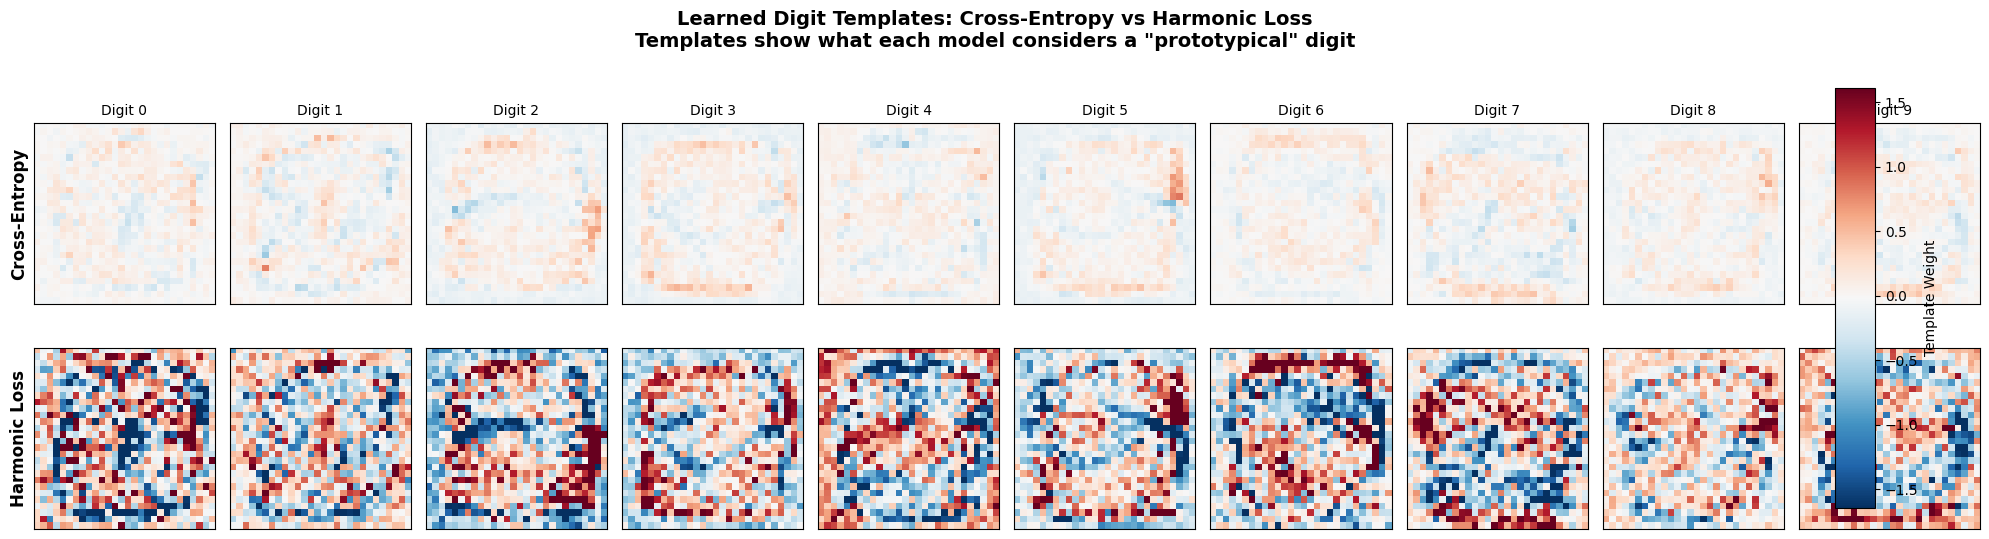


Template Analysis:
------------------------------
Average template distinctiveness:
  Cross-Entropy: 0.9830 (±0.1305)
  Harmonic Loss: 1.1050 (±0.0273)

Average template sparsity (higher = more concentrated):
  Cross-Entropy: 0.4523 (±0.0310)
  Harmonic Loss: 0.4628 (±0.0277)
  ✓ Harmonic Loss templates are more distinctive
  ✓ Harmonic Loss templates are more concentrated/sparse

Analyzing template differences...

Template Difference Analysis:
------------------------------


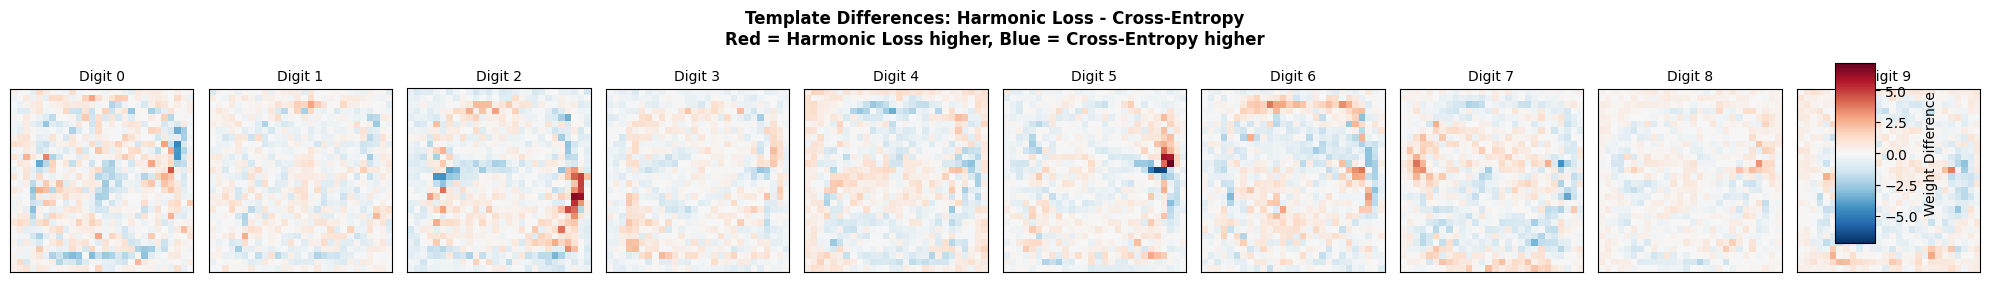

  Digit 0: Average absolute difference = 0.7741
  Digit 1: Average absolute difference = 0.5198
  Digit 2: Average absolute difference = 0.7675
  Digit 3: Average absolute difference = 0.5147
  Digit 4: Average absolute difference = 0.6978
  Digit 5: Average absolute difference = 0.5903
  Digit 6: Average absolute difference = 0.6990
  Digit 7: Average absolute difference = 0.6624
  Digit 8: Average absolute difference = 0.4080
  Digit 9: Average absolute difference = 0.5387


In [9]:
# ===================================================================
# CELL 8.5: Visual Digit Templates Comparison (sin fc2)
# ===================================================================

print("VISUAL DIGIT TEMPLATES COMPARISON")
print("=" * 50)

def extract_digit_templates(model, model_name):
    """
    Extrae plantillas visuales de dígitos mapeando los pesos del clasificador
    directamente al espacio de entrada a través de fc1.
    """
    model.eval()

    # Pesos
    fc1_weight = model.fc1.weight.data        # [H, 784]
    classifier_weight = model.classifier.weight.data  # [10, H]

    print(f"Extracting templates for {model_name}...")
    print(f"  - Classifier weights shape: {classifier_weight.shape}")
    print(f"  - FC1 weights shape: {fc1_weight.shape}")

    # Map classifier -> fc1 -> input_space
    input_templates = torch.matmul(classifier_weight, fc1_weight)  # [10, 784]

    # Reshape a formato imagen [10, 28, 28]
    digit_templates = input_templates.view(10, 28, 28)

    return digit_templates.cpu().numpy()

def visualize_digit_templates(ce_model, harmonic_model):
    """
    Compara lado a lado las plantillas aprendidas por cada modelo.
    """
    # Extraer plantillas de ambos modelos
    ce_templates = extract_digit_templates(ce_model, "Cross-Entropy")
    harmonic_templates = extract_digit_templates(harmonic_model, "Harmonic Loss")

    # Crear visualización
    fig, axes = plt.subplots(2, 10, figsize=(20, 6))
    fig.suptitle('Learned Digit Templates: Cross-Entropy vs Harmonic Loss\n' +
                 'Templates show what each model considers a "prototypical" digit',
                 fontsize=14, fontweight='bold')

    # Min/max global para escala de colores
    all_templates = np.concatenate([ce_templates.flatten(), harmonic_templates.flatten()])
    vmin, vmax = np.percentile(all_templates, [2, 98])

    # Plantillas Cross-Entropy (fila superior)
    for digit in range(10):
        im1 = axes[0, digit].imshow(ce_templates[digit], cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axes[0, digit].set_title(f'Digit {digit}', fontsize=10)
        axes[0, digit].set_xticks([])
        axes[0, digit].set_yticks([])

        if digit == 0:
            axes[0, digit].set_ylabel('Cross-Entropy', fontsize=12, fontweight='bold', rotation=90)

    # Plantillas Harmonic Loss (fila inferior)
    for digit in range(10):
        im2 = axes[1, digit].imshow(harmonic_templates[digit], cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axes[1, digit].set_xticks([])
        axes[1, digit].set_yticks([])

        if digit == 0:
            axes[1, digit].set_ylabel('Harmonic Loss', fontsize=12, fontweight='bold', rotation=90)

    # Barra de color
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im1, cax=cbar_ax, label='Template Weight')
    plt.show()

    # Análisis cuantitativo
    print("\nTemplate Analysis:")
    print("-" * 30)

    # Distinctiveness
    def compute_template_distinctiveness(templates):
        distinctiveness = []
        for i in range(10):
            template_i = templates[i].flatten()
            similarities = []
            for j in range(10):
                if i != j:
                    template_j = templates[j].flatten()
                    similarity = np.dot(template_i, template_j) / (np.linalg.norm(template_i) * np.linalg.norm(template_j))
                    similarities.append(similarity)
            distinctiveness.append(1.0 - np.mean(similarities))
        return distinctiveness

    ce_distinctiveness = compute_template_distinctiveness(ce_templates)
    harmonic_distinctiveness = compute_template_distinctiveness(harmonic_templates)

    print(f"Average template distinctiveness:")
    print(f"  Cross-Entropy: {np.mean(ce_distinctiveness):.4f} (±{np.std(ce_distinctiveness):.4f})")
    print(f"  Harmonic Loss: {np.mean(harmonic_distinctiveness):.4f} (±{np.std(harmonic_distinctiveness):.4f})")

    # Sparsity
    def compute_sparsity(templates):
        sparsities = []
        for i in range(10):
            template = templates[i].flatten()
            abs_sorted = np.sort(np.abs(template))
            n = len(abs_sorted)
            total = abs_sorted.sum()
            if total == 0:
                sparsities.append(0.0)
                continue
            gini = (2 * np.sum((np.arange(n) + 1) * abs_sorted)) / (n * total) - (n + 1) / n
            sparsities.append(gini)
        return sparsities

    ce_sparsity = compute_sparsity(ce_templates)
    harmonic_sparsity = compute_sparsity(harmonic_templates)

    print(f"\nAverage template sparsity (higher = more concentrated):")
    print(f"  Cross-Entropy: {np.mean(ce_sparsity):.4f} (±{np.std(ce_sparsity):.4f})")
    print(f"  Harmonic Loss: {np.mean(harmonic_sparsity):.4f} (±{np.std(harmonic_sparsity):.4f})")

    if np.mean(harmonic_distinctiveness) > np.mean(ce_distinctiveness):
        print("  ✓ Harmonic Loss templates are more distinctive")
    else:
        print("  ✓ Cross-Entropy templates are more distinctive")

    if np.mean(harmonic_sparsity) > np.mean(ce_sparsity):
        print("  ✓ Harmonic Loss templates are more concentrated/sparse")
    else:
        print("  ✓ Cross-Entropy templates are more concentrated/sparse")

    return ce_templates, harmonic_templates

def create_template_difference_analysis(ce_templates, harmonic_templates):
    """
    Analiza diferencias entre los dos conjuntos de plantillas.
    """
    print("\nTemplate Difference Analysis:")
    print("-" * 30)

    # Diferencias pixel a pixel
    differences = harmonic_templates - ce_templates

    # Visualizar
    fig, axes = plt.subplots(1, 10, figsize=(20, 3))
    fig.suptitle('Template Differences: Harmonic Loss - Cross-Entropy\n' +
                 'Red = Harmonic Loss higher, Blue = Cross-Entropy higher',
                 fontsize=12, fontweight='bold')

    diff_max = np.max(np.abs(differences))

    for digit in range(10):
        im = axes[digit].imshow(differences[digit], cmap='RdBu_r', vmin=-diff_max, vmax=diff_max)
        axes[digit].set_title(f'Digit {digit}', fontsize=10)
        axes[digit].set_xticks([])
        axes[digit].set_yticks([])

    plt.tight_layout()
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(im, cax=cbar_ax, label='Weight Difference')
    plt.show()

    # Estadísticas
    for digit in range(10):
        diff_magnitude = np.mean(np.abs(differences[digit]))
        print(f"  Digit {digit}: Average absolute difference = {diff_magnitude:.4f}")

# Run
print("Extracting and visualizing digit templates...")
ce_templates, harmonic_templates = visualize_digit_templates(ce_model, harmonic_model)

print("\nAnalyzing template differences...")
create_template_difference_analysis(ce_templates, harmonic_templates)

print("=" * 60)


VISUAL DIGIT REPRESENTATIONS COMPARISON
Generating digit representation visualizations...
Computing average activations per digit class...


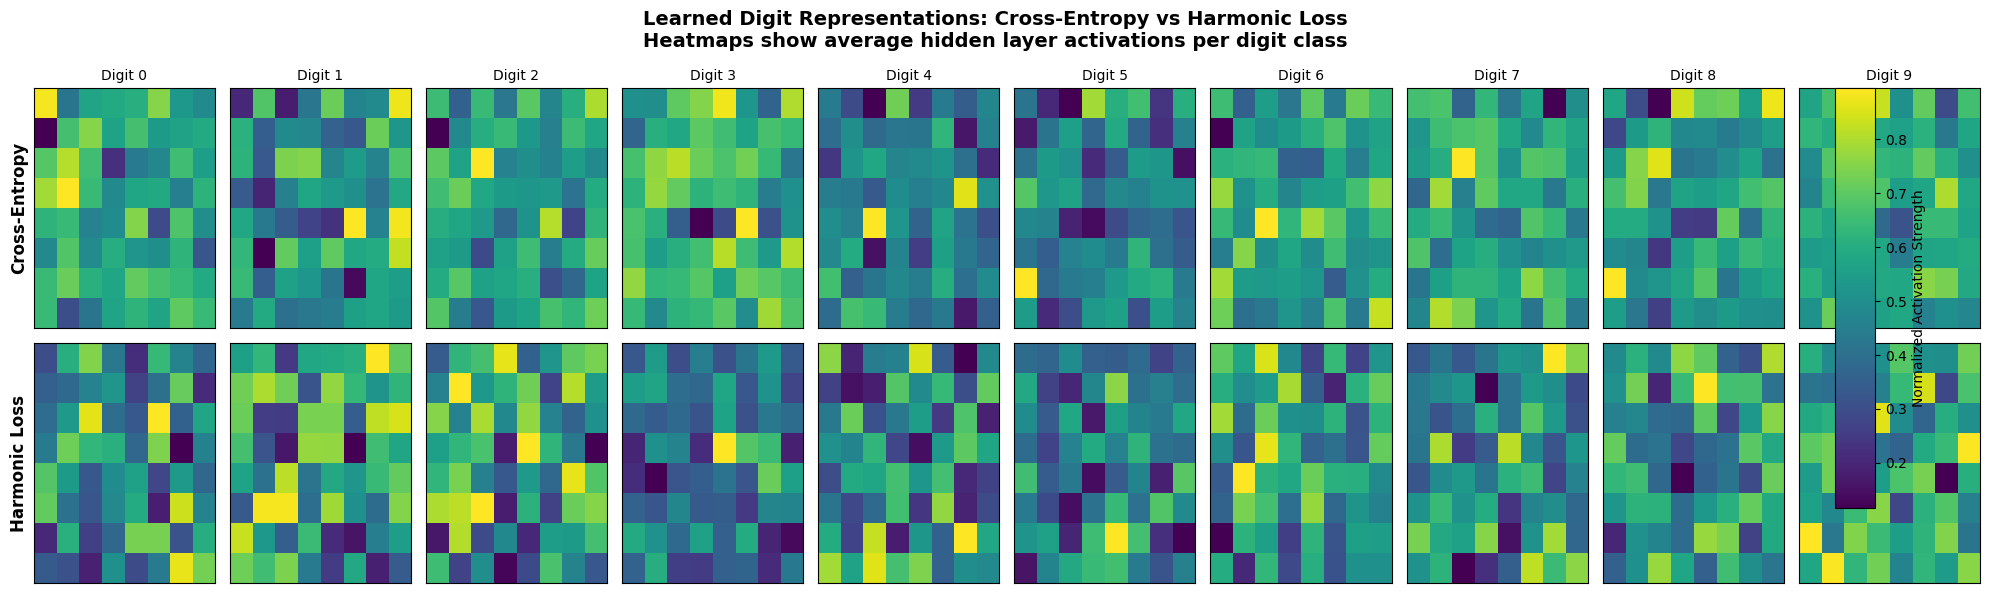


Representation Analysis:
------------------------------
Average representation diversity:
  Cross-Entropy: 2.8016 (±0.3487)
  Harmonic Loss: 1.2962 (±0.2407)

Average inter-digit similarity:
  Cross-Entropy: 0.1513
  Harmonic Loss: -0.0542
  ✓ Harmonic Loss creates more distinct digit representations

Generating similarity analysis...


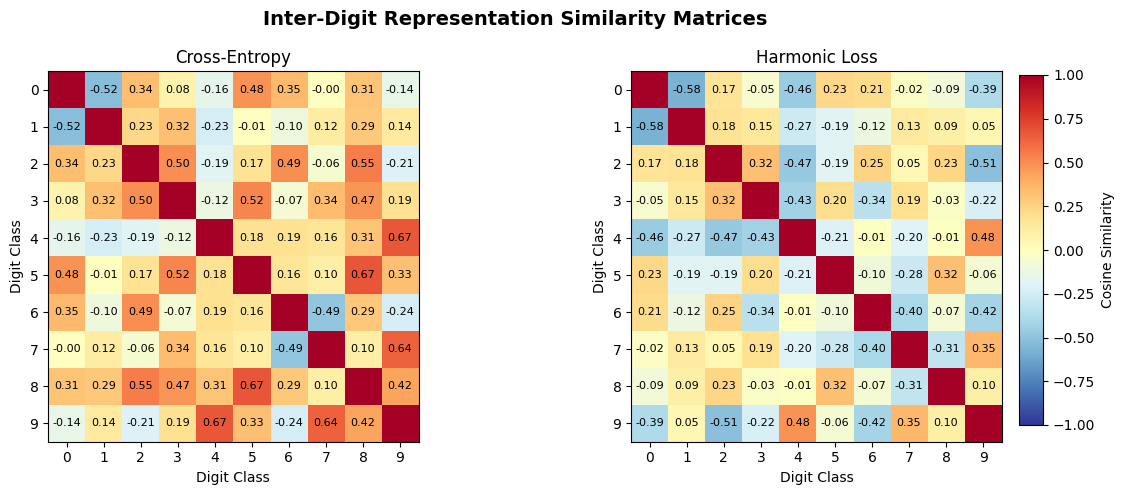

In [10]:
# ===================================================================
# CELL 8.5: Visual Digit Representations Comparison
# ===================================================================

print("VISUAL DIGIT REPRESENTATIONS COMPARISON")
print("=" * 50)

def compute_average_activations_per_class(model, test_loader, device, num_samples_per_class=100):
    """
    Compute average hidden layer activations for each digit class.
    This shows what patterns each model has learned to recognize.
    """
    model.eval()

    # Store activations by class
    activations_by_class = {i: [] for i in range(10)}
    samples_per_class = {i: 0 for i in range(10)}

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Get hidden features (before final classification)
            hidden_features, _ = model(data)

            # Collect activations by class
            for i in range(len(targets)):
                class_label = targets[i].item()
                if samples_per_class[class_label] < num_samples_per_class:
                    activations_by_class[class_label].append(hidden_features[i].cpu())
                    samples_per_class[class_label] += 1

            # Stop if we have enough samples for all classes
            if all(count >= num_samples_per_class for count in samples_per_class.values()):
                break

    # Compute averages
    avg_activations = {}
    for class_label in range(10):
        if activations_by_class[class_label]:
            class_activations = torch.stack(activations_by_class[class_label])
            avg_activations[class_label] = torch.mean(class_activations, dim=0)
        else:
            avg_activations[class_label] = torch.zeros(model.hidden_size)

    return avg_activations

def visualize_learned_digit_patterns(ce_model, harmonic_model, test_loader, device):
    """
    Create visual comparison of what each model has learned for each digit.
    """
    print("Computing average activations per digit class...")

    # Get average activations for both models
    ce_activations = compute_average_activations_per_class(ce_model, test_loader, device)
    harmonic_activations = compute_average_activations_per_class(harmonic_model, test_loader, device)

    # Create visualization
    fig, axes = plt.subplots(2, 10, figsize=(20, 6))
    fig.suptitle('Learned Digit Representations: Cross-Entropy vs Harmonic Loss\n' +
                 'Heatmaps show average hidden layer activations per digit class',
                 fontsize=14, fontweight='bold')

    # Normalize activations for better visualization
    def normalize_for_vis(activations_dict):
        all_values = torch.cat([act for act in activations_dict.values()])
        min_val, max_val = all_values.min(), all_values.max()
        normalized = {}
        for k, v in activations_dict.items():
            normalized[k] = (v - min_val) / (max_val - min_val)
        return normalized

    ce_norm = normalize_for_vis(ce_activations)
    harmonic_norm = normalize_for_vis(harmonic_activations)

    # Plot Cross-Entropy representations (top row)
    for digit in range(10):
        # Reshape to roughly square for visualization
        size = int(np.sqrt(len(ce_norm[digit])))
        if size * size < len(ce_norm[digit]):
            size += 1

        # Pad if necessary
        padded = torch.zeros(size * size)
        padded[:len(ce_norm[digit])] = ce_norm[digit]
        reshaped = padded.view(size, size).numpy()

        im1 = axes[0, digit].imshow(reshaped, cmap='viridis', aspect='auto')
        axes[0, digit].set_title(f'Digit {digit}', fontsize=10)
        axes[0, digit].set_xticks([])
        axes[0, digit].set_yticks([])

        if digit == 0:
            axes[0, digit].set_ylabel('Cross-Entropy', fontsize=12, fontweight='bold')

    # Plot Harmonic Loss representations (bottom row)
    for digit in range(10):
        # Reshape to roughly square for visualization
        size = int(np.sqrt(len(harmonic_norm[digit])))
        if size * size < len(harmonic_norm[digit]):
            size += 1

        # Pad if necessary
        padded = torch.zeros(size * size)
        padded[:len(harmonic_norm[digit])] = harmonic_norm[digit]
        reshaped = padded.view(size, size).numpy()

        im2 = axes[1, digit].imshow(reshaped, cmap='viridis', aspect='auto')
        axes[1, digit].set_xticks([])
        axes[1, digit].set_yticks([])

        if digit == 0:
            axes[1, digit].set_ylabel('Harmonic Loss', fontsize=12, fontweight='bold')

    # Add colorbar
    plt.tight_layout()

    # Add a colorbar to the right
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im1, cax=cbar_ax, label='Normalized Activation Strength')

    plt.show()

    # Print analysis
    print("\nRepresentation Analysis:")
    print("-" * 30)

    # Compute representation diversity (standard deviation across features)
    ce_diversity = [torch.std(ce_activations[i]).item() for i in range(10)]
    harmonic_diversity = [torch.std(harmonic_activations[i]).item() for i in range(10)]

    print(f"Average representation diversity:")
    print(f"  Cross-Entropy: {np.mean(ce_diversity):.4f} (±{np.std(ce_diversity):.4f})")
    print(f"  Harmonic Loss: {np.mean(harmonic_diversity):.4f} (±{np.std(harmonic_diversity):.4f})")

    # Compute pairwise similarities between digit representations
    def compute_pairwise_similarities(activations_dict):
        similarities = np.zeros((10, 10))
        for i in range(10):
            for j in range(10):
                if i != j:
                    cosine_sim = F.cosine_similarity(
                        activations_dict[i].unsqueeze(0),
                        activations_dict[j].unsqueeze(0)
                    ).item()
                    similarities[i, j] = cosine_sim
        return similarities

    ce_similarities = compute_pairwise_similarities(ce_activations)
    harmonic_similarities = compute_pairwise_similarities(harmonic_activations)

    print(f"\nAverage inter-digit similarity:")
    print(f"  Cross-Entropy: {np.mean(ce_similarities):.4f}")
    print(f"  Harmonic Loss: {np.mean(harmonic_similarities):.4f}")

    # Lower similarity means more distinct representations
    if np.mean(harmonic_similarities) < np.mean(ce_similarities):
        print("  ✓ Harmonic Loss creates more distinct digit representations")
    else:
        print("  ✓ Cross-Entropy creates more distinct digit representations")

    return ce_activations, harmonic_activations

def create_similarity_heatmaps(ce_activations, harmonic_activations):
    """
    Create heatmaps showing similarity between digit representations.
    """
    def compute_similarity_matrix(activations_dict):
        similarities = np.zeros((10, 10))
        for i in range(10):
            for j in range(10):
                cosine_sim = F.cosine_similarity(
                    activations_dict[i].unsqueeze(0),
                    activations_dict[j].unsqueeze(0)
                ).item()
                similarities[i, j] = cosine_sim
        return similarities

    ce_sim_matrix = compute_similarity_matrix(ce_activations)
    harmonic_sim_matrix = compute_similarity_matrix(harmonic_activations)

    # Create comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Inter-Digit Representation Similarity Matrices', fontsize=14, fontweight='bold')

    # Cross-Entropy similarity
    im1 = axes[0].imshow(ce_sim_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
    axes[0].set_title('Cross-Entropy')
    axes[0].set_xlabel('Digit Class')
    axes[0].set_ylabel('Digit Class')
    axes[0].set_xticks(range(10))
    axes[0].set_yticks(range(10))

    # Add correlation values as text
    for i in range(10):
        for j in range(10):
            if i != j:  # Don't show diagonal (always 1.0)
                text = axes[0].text(j, i, f'{ce_sim_matrix[i, j]:.2f}',
                                   ha="center", va="center", fontsize=8)

    # Harmonic Loss similarity
    im2 = axes[1].imshow(harmonic_sim_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
    axes[1].set_title('Harmonic Loss')
    axes[1].set_xlabel('Digit Class')
    axes[1].set_ylabel('Digit Class')
    axes[1].set_xticks(range(10))
    axes[1].set_yticks(range(10))

    # Add correlation values as text
    for i in range(10):
        for j in range(10):
            if i != j:  # Don't show diagonal (always 1.0)
                text = axes[1].text(j, i, f'{harmonic_sim_matrix[i, j]:.2f}',
                                   ha="center", va="center", fontsize=8)

    # Add colorbar
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im1, cax=cbar_ax, label='Cosine Similarity')

    plt.show()

# Run the analysis
print("Generating digit representation visualizations...")
ce_acts, harmonic_acts = visualize_learned_digit_patterns(ce_model, harmonic_model, test_loader, device)

print("\nGenerating similarity analysis...")
create_similarity_heatmaps(ce_acts, harmonic_acts)

print("=" * 60)

INTERPRETABILITY ANALYSIS: WEIGHT VISUALIZATION
Analyzing Cross-Entropy Model Weights...


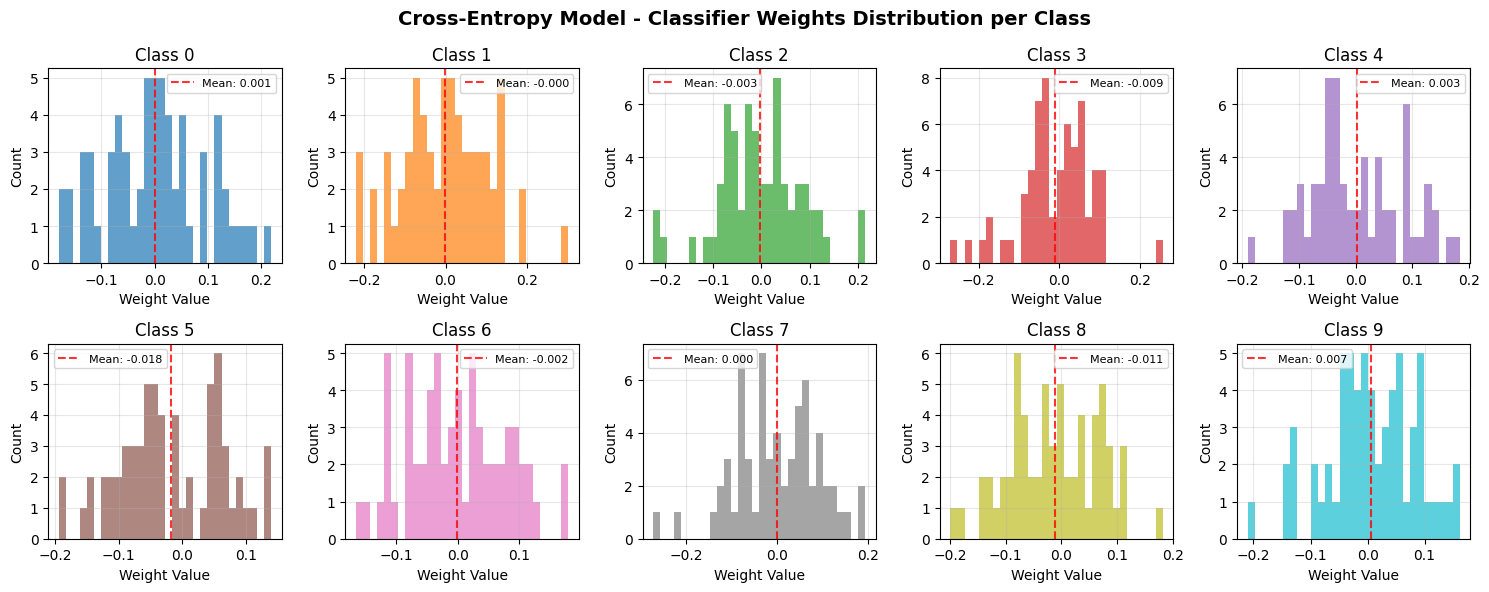


Cross-Entropy Interpretability Metrics:
  Weight Norm Statistics:
    - Mean: 0.6971
    - Std:  0.0643
    - Min:  0.6274
    - Max:  0.8432

Analyzing Harmonic Loss Model Weights...


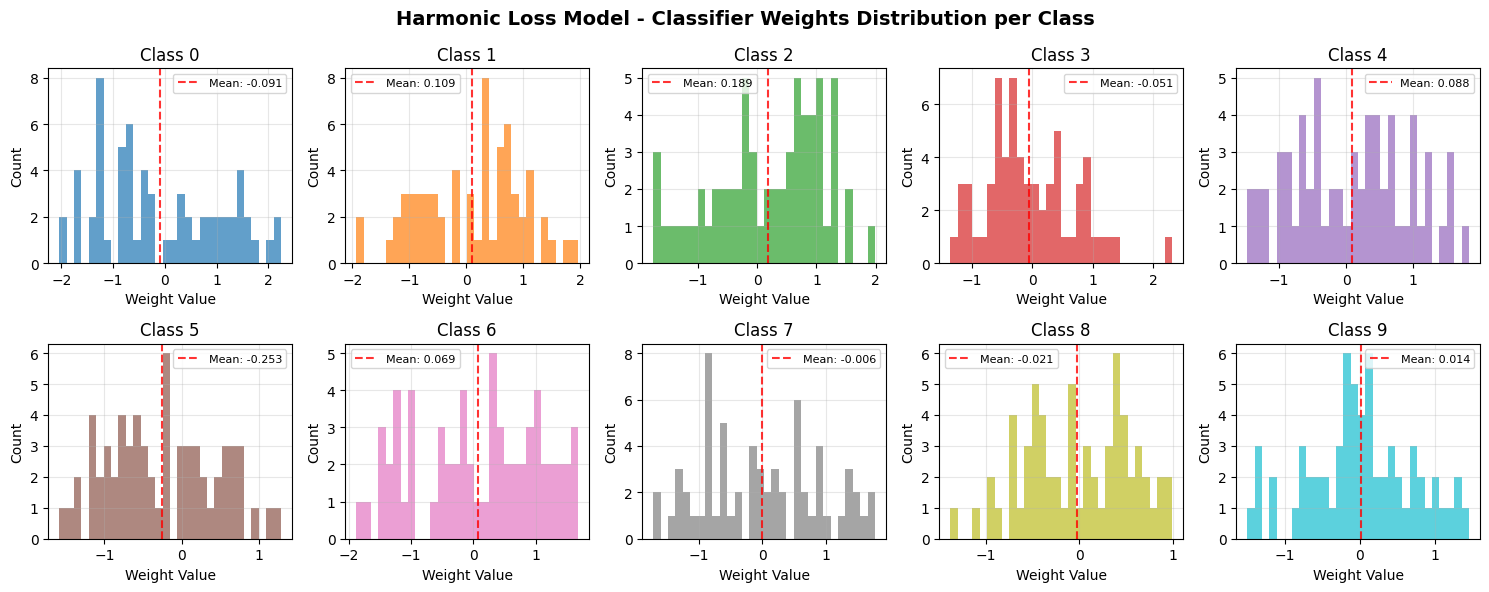


Harmonic Loss Interpretability Metrics:
  Weight Norm Statistics:
    - Mean: 6.7804
    - Std:  1.2939
    - Min:  4.4877
    - Max:  9.2616


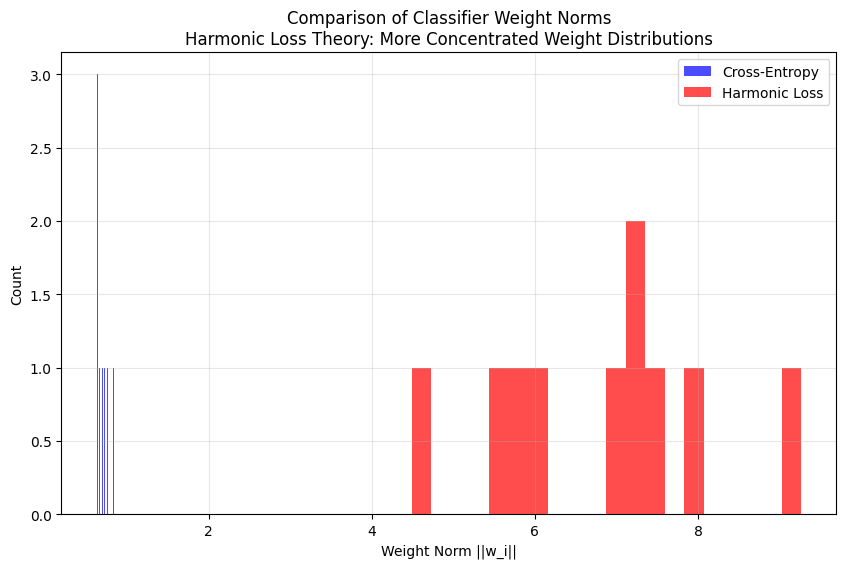


Weight Norm Comparison:
  Cross-Entropy - Mean: 0.6971, Std: 0.0643
  Harmonic Loss - Mean: 6.7804, Std: 1.2939


In [11]:
# ===================================================================
# CELL 9: Interpretability Analysis - Weight Visualization
# ===================================================================

print("INTERPRETABILITY ANALYSIS: WEIGHT VISUALIZATION")
print("=" * 50)

def visualize_classifier_weights(model, title, model_type):
    """
    Visualize classifier layer weights as digit templates.

    According to Harmonic Loss theory, weights should align with class centers
    providing better interpretability.
    """
    # Get classifier weights
    weights = model.classifier.weight.data.cpu()  # [10, 128]

    # We can't directly visualize 128-dim weights as images, but we can show their statistics
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f'{title} - Classifier Weights Distribution per Class', fontsize=14, fontweight='bold')

    for i in range(10):
        row = i // 5
        col = i % 5

        class_weights = weights[i].numpy()

        # Plot histogram of weights for this class
        axes[row, col].hist(class_weights, bins=30, alpha=0.7, color=plt.cm.tab10(i))
        axes[row, col].set_title(f'Class {i}')
        axes[row, col].set_xlabel('Weight Value')
        axes[row, col].set_ylabel('Count')
        axes[row, col].grid(True, alpha=0.3)

        # Add statistics
        mean_weight = np.mean(class_weights)
        std_weight = np.std(class_weights)
        axes[row, col].axvline(mean_weight, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_weight:.3f}')
        axes[row, col].legend(fontsize=8)

    plt.tight_layout()
    plt.show()

    # Compute interpretability metrics
    weight_norms = torch.norm(weights, dim=1).numpy()
    print(f"\n{model_type} Interpretability Metrics:")
    print(f"  Weight Norm Statistics:")
    print(f"    - Mean: {np.mean(weight_norms):.4f}")
    print(f"    - Std:  {np.std(weight_norms):.4f}")
    print(f"    - Min:  {np.min(weight_norms):.4f}")
    print(f"    - Max:  {np.max(weight_norms):.4f}")

    return weight_norms

# Analyze both models
print("Analyzing Cross-Entropy Model Weights...")
ce_norms = visualize_classifier_weights(ce_model, "Cross-Entropy Model", "Cross-Entropy")

print("\nAnalyzing Harmonic Loss Model Weights...")
harmonic_norms = visualize_classifier_weights(harmonic_model, "Harmonic Loss Model", "Harmonic Loss")

# Compare weight norm distributions
plt.figure(figsize=(10, 6))
plt.hist(ce_norms, bins=20, alpha=0.7, label='Cross-Entropy', color='blue')
plt.hist(harmonic_norms, bins=20, alpha=0.7, label='Harmonic Loss', color='red')
plt.xlabel('Weight Norm ||w_i||')
plt.ylabel('Count')
plt.title('Comparison of Classifier Weight Norms\nHarmonic Loss Theory: More Concentrated Weight Distributions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nWeight Norm Comparison:")
print(f"  Cross-Entropy - Mean: {np.mean(ce_norms):.4f}, Std: {np.std(ce_norms):.4f}")
print(f"  Harmonic Loss - Mean: {np.mean(harmonic_norms):.4f}, Std: {np.std(harmonic_norms):.4f}")
print("=" * 60)


ADVANCED INTERPRETABILITY: DISTANCE-BASED ANALYSIS
Analyzing Cross-Entropy Model Prediction Behavior...


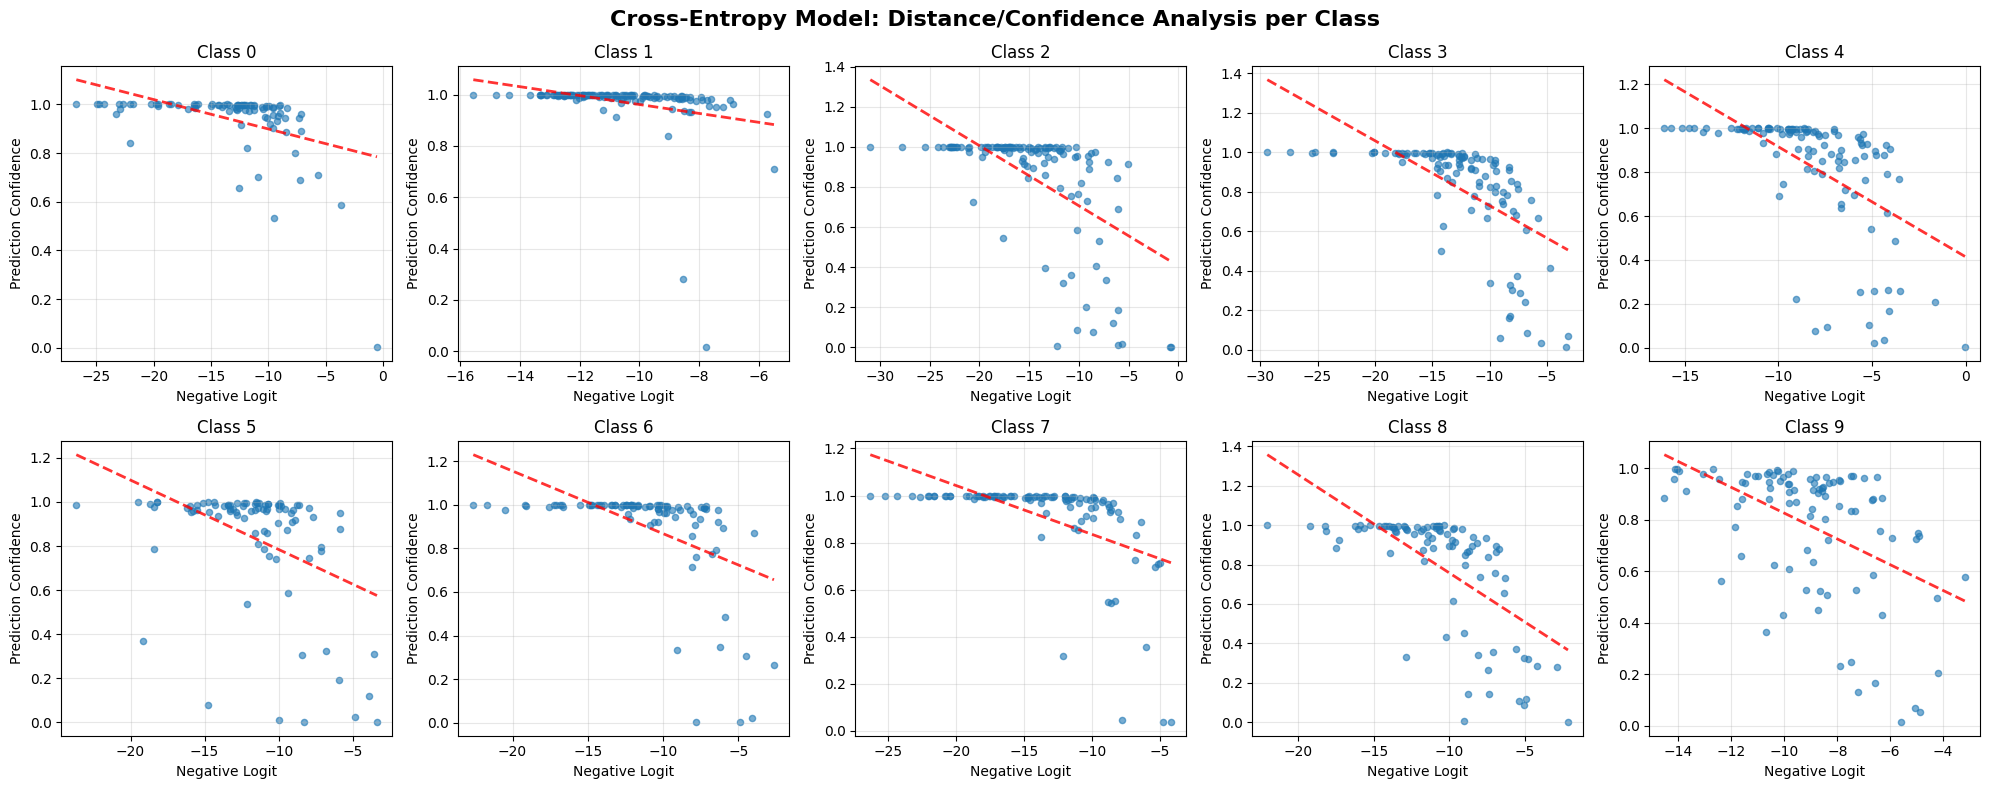


Cross-Entropy Distance Analysis Results (on 1000 samples):
  - Accuracy: 90.60%
  - Average Neg. Logit: -11.5965
  - Average Confidence: 0.8628

Analyzing Harmonic Loss Model Prediction Behavior...


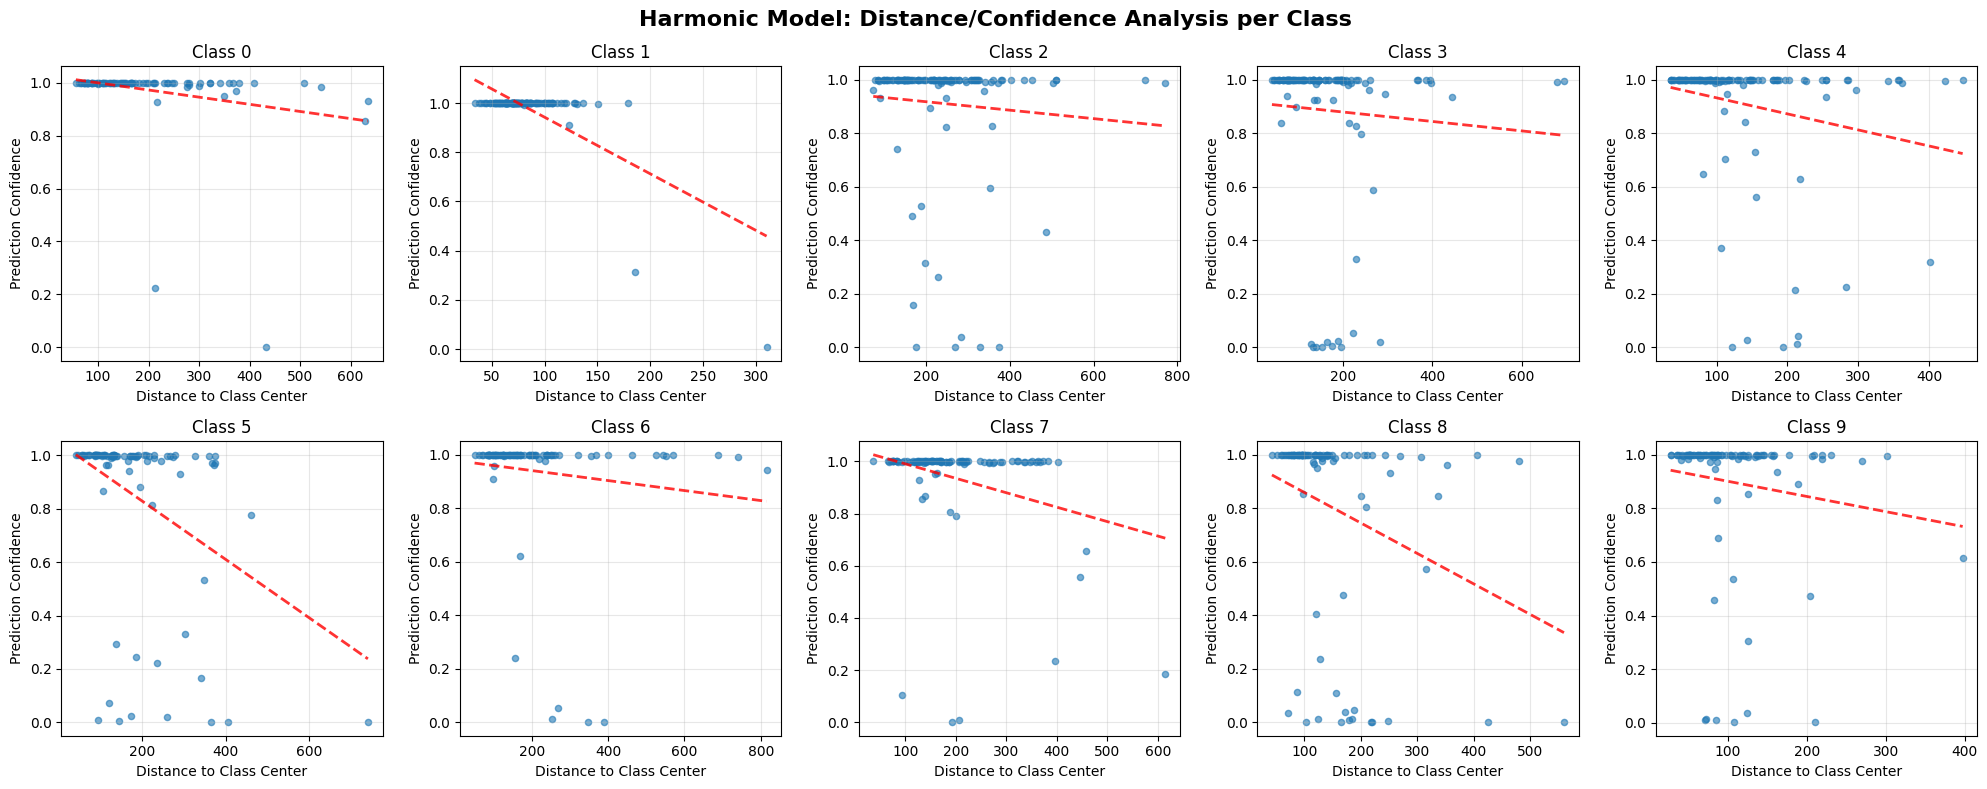


Harmonic Distance Analysis Results (on 1000 samples):
  - Accuracy: 91.70%
  - Average Distance: 166.6775
  - Average Confidence: 0.9087


In [12]:
# ===================================================================
# CELL 10: Advanced Interpretability - Distance Analysis
# ===================================================================

print("ADVANCED INTERPRETABILITY: DISTANCE-BASED ANALYSIS")
print("=" * 50)

def analyze_prediction_distances(model, loss_fn, test_loader, device, model_type, num_samples=1000):
    """
    Analyze prediction behavior through distance-based metrics.

    For Harmonic Loss, this shows how the model makes decisions based on
    distances to class centers rather than dot products.
    """
    model.eval()

    distances_by_class = defaultdict(list)
    confidences_by_class = defaultdict(list)
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        sample_count = 0
        for data, targets in test_loader:
            if sample_count >= num_samples:
                break

            data, targets = data.to(device), targets.to(device)
            hidden_features, logits = model(data)

            if model_type == "Harmonic":
                # For Harmonic Loss, compute distances directly
                weight_matrix = model.classifier.weight

                # Compute distances using the same method as training
                batch_size = hidden_features.shape[0]

                # Standard matrix multiplication
                y = F.linear(hidden_features, weight_matrix)

                # Compute norms
                x2 = (hidden_features * hidden_features).sum(dim=-1, keepdim=True)
                w2 = (weight_matrix * weight_matrix).sum(dim=-1)

                # Compute distances
                distances = x2 + w2.unsqueeze(0) - 2.0 * y
                distances = torch.clamp_min(distances, 1e-6)

                # Get predictions from harmonic logits
                harmonic_logits = -loss_fn.harmonic_n * torch.log(distances)
                probabilities = F.softmax(harmonic_logits, dim=1)
                _, predicted = torch.max(harmonic_logits, 1)

            else:
                # For Cross-Entropy, use standard logits
                distances = -logits  # Negative logits as "distance" proxy
                probabilities = F.softmax(logits, dim=1)
                _, predicted = torch.max(logits, 1)

            # Collect statistics
            for i in range(len(targets)):
                true_class = targets[i].item()
                pred_class = predicted[i].item()

                if model_type == "Harmonic":
                    # Distance to true class (smaller is better)
                    true_class_distance = distances[i, true_class].item()
                else:
                    # For CE, use negative logit as distance proxy
                    true_class_distance = -logits[i, true_class].item()

                confidence = probabilities[i, true_class].item()

                distances_by_class[true_class].append(true_class_distance)
                confidences_by_class[true_class].append(confidence)

                if pred_class == true_class:
                    correct_predictions += 1
                total_predictions += 1
                sample_count += 1

                if sample_count >= num_samples:
                    break

            if sample_count >= num_samples:
                break

    # Create visualization
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(f'{model_type} Model: Distance/Confidence Analysis per Class', fontsize=16, fontweight='bold')

    for class_idx in range(10):
        row = class_idx // 5
        col = class_idx % 5

        if class_idx in distances_by_class:
            class_distances = distances_by_class[class_idx]
            class_confidences = confidences_by_class[class_idx]

            # Scatter plot: distance vs confidence
            scatter = axes[row, col].scatter(class_distances, class_confidences, alpha=0.6, s=20)
            axes[row, col].set_title(f'Class {class_idx}')
            axes[row, col].set_xlabel('Distance to Class Center' if model_type == "Harmonic" else 'Negative Logit')
            axes[row, col].set_ylabel('Prediction Confidence')
            axes[row, col].grid(True, alpha=0.3)

            # Add trend line
            if len(class_distances) > 1:
                z = np.polyfit(class_distances, class_confidences, 1)
                p = np.poly1d(z)
                x_trend = np.linspace(min(class_distances), max(class_distances), 100)
                axes[row, col].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.show()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"\n{model_type} Distance Analysis Results (on {sample_count} samples):")
    print(f"  - Accuracy: {accuracy:.2f}%")

    # Compute average distances and confidences
    avg_distances = [np.mean(distances_by_class[i]) for i in range(10) if i in distances_by_class]
    avg_confidences = [np.mean(confidences_by_class[i]) for i in range(10) if i in confidences_by_class]

    print(f"  - Average {'Distance' if model_type == 'Harmonic' else 'Neg. Logit'}: {np.mean(avg_distances):.4f}")
    print(f"  - Average Confidence: {np.mean(avg_confidences):.4f}")

    return distances_by_class, confidences_by_class

# Analyze both models
print("Analyzing Cross-Entropy Model Prediction Behavior...")
ce_distances, ce_confidences = analyze_prediction_distances(
    ce_model, None, test_loader, device, "Cross-Entropy"
)

print("\nAnalyzing Harmonic Loss Model Prediction Behavior...")
harmonic_distances, harmonic_confidences = analyze_prediction_distances(
    harmonic_model, harmonic_loss_fn, test_loader, device, "Harmonic"
)

print("=" * 60)